# Multi-scale Clustering Analysis of Wildfire Hazards and Machine Learning-based Burn Severity Prediction
## Sampling method2: Fixed random sampling

## Required libraries and dependencies

In [17]:
import rasterio, os, glob, warnings, time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.inspection import permutation_importance 

from sampling import *
from utils import *

warnings.filterwarnings("ignore")
plt.rcParams["figure.autolayout"] = True

## Input Paths and Data
Change data paths to local

In [18]:
# Input image paths
basepath = '/Users/minho/Documents/GitHub/explainableFire/datasets'
# os.chdir(path)

# img_train = sorted(glob.glob('s2*.tif'))
# dem_train = sorted(glob.glob('dem*.tif'))
# slope_train = sorted(glob.glob('slope*.tif'))
# aoi_train = sorted(glob.glob('fire*.tif'))
# lulc_train = sorted(glob.glob('lulc*.tif'))

# Weather data
# rmin_train = sorted(glob.glob('rmin*.tif'))
# rmax_train = sorted(glob.glob('rmax*.tif'))
# tmmn_train = sorted(glob.glob('tmmn*.tif'))
# tmmx_train = sorted(glob.glob('tmmx*.tif'))
# vs_train = sorted(glob.glob('vs*.tif'))

In [25]:
# Input Parameters
number_of_sample_points = 10000 # This selects the number of samples from each burn severity class
random_state = 42 # Random seed number to keep consistent
input_bands = 5 # Number of features in the training dataset (10) and with weather (10 + 5)
patch_size = 32
fixed_sample_num = 300

## Sampling
- Total samples: 10,000 samples (points at 10m resolution) with 2,500 samples for each burn severity class
- Split: Frequency relative to total pixel count for each burn severity class
- Method: Random sampling 

In [26]:
# Create input dataset stack
img_train, dem_train, slope_train, lulc_train, aoi_train = paths(basepath)

img_size_list = []

for i in range(len(img_train)):
    img, img_meta = open_multiband(img_train[i])    
    img_size_list.append(img.shape[0]*img.shape[1])    
    
del img_meta 

img_size_df = pd.DataFrame(columns = ['size', 'weight','weighted_pix', 'low','low-med','med-high','high'])
img_size_df.size = img_size_list
# img_size_df.reset_index(level=0, inplace=True)

# Random sampling for each image (based on AOI size and burn severity class frequency)
for i in range(len(img_size_df)):
    img_size_df['weight'][i] = img_size_df['size'][i]/img_size_df['size'].sum()
    img_size_df['weighted_pix'][i] = img_size_df['weight'][i]*100

    aoi, aoi_meta = open_data(aoi_train[i])
    aoi[aoi > 4] = 0 # Set nodata values to 0 or NaN
    
    img_size_df['low'][i] = len(aoi[aoi==1])
    img_size_df['low-med'][i] = len(aoi[aoi==2])
    img_size_df['med-high'][i] = len(aoi[aoi==3])
    img_size_df['high'][i] = len(aoi[aoi==4])
    
del aoi_meta

burn_sev_df = img_size_df.copy().drop(columns = ['size','weight','weighted_pix'])

for i in range(len(img_size_df)):
    burn_sev_df['low'][i] = img_size_df['low'][i]/img_size_df['low'].sum()*number_of_sample_points
    burn_sev_df['low-med'][i] = img_size_df['low-med'][i]/img_size_df['low-med'].sum()*number_of_sample_points
    burn_sev_df['med-high'][i] = img_size_df['med-high'][i]/img_size_df['med-high'].sum()*number_of_sample_points
    burn_sev_df['high'][i] = img_size_df['high'][i]/img_size_df['high'].sum()*number_of_sample_points

# Processing methods (Choose ONE)
- Method 0 : Patch based averages --> 18 features
- Method 1 : Random sampling --> 10 features
- Method 2 : Fixed sampling --> 10 features
- Method 3 : Random + Fixed sampling using dataset split in chronological order
- Method 4 : Patch sampling --> 10 features (for deep learning : creates 4d tensors)
** eg. (# samples, patch_x, patch_y, # features)

## Method 2: Fixed number of random samples

In [27]:
# Set AOI sample counts
df1 = burn_sev_df.round(0).astype(int)

# Set empty placeholders for training dataset
low_train = pd.DataFrame(columns = ['c1','c2','features'])
mlow_train = pd.DataFrame(columns = ['c1','c2','features'])
mhigh_train = pd.DataFrame(columns = ['c1','c2','features'])
high_train = pd.DataFrame(columns = ['c1','c2','features'])

df1['low']= fixed_sample_num
df1['low-med'] = fixed_sample_num
df1['med-high'] = fixed_sample_num
df1['high'] = fixed_sample_num

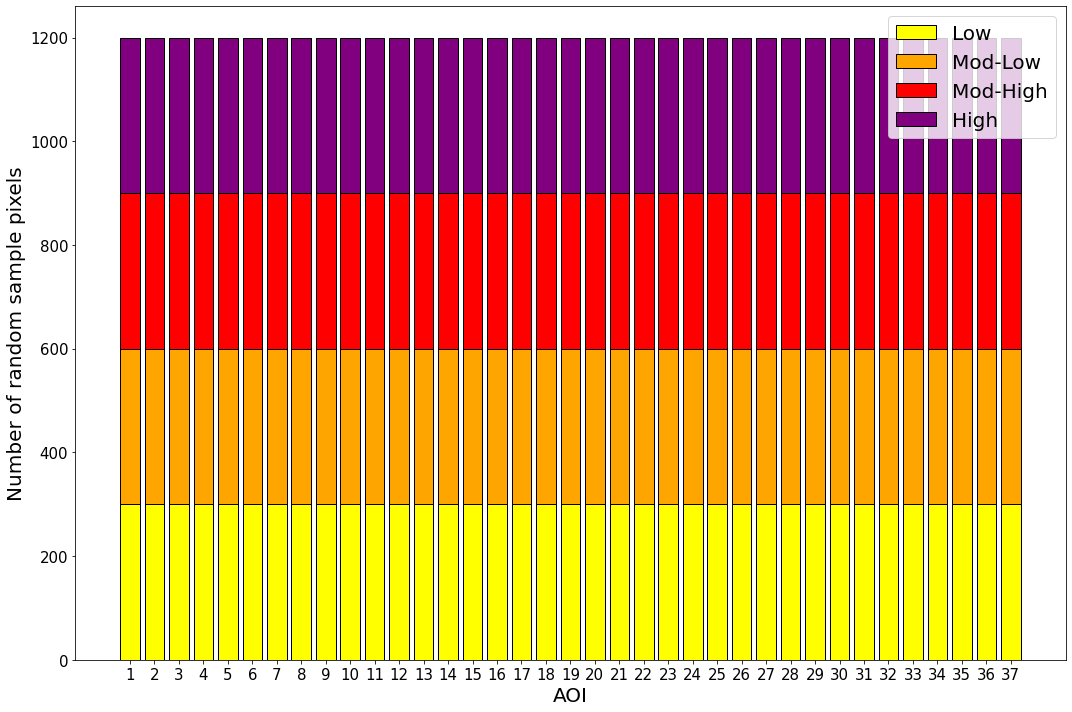

In [28]:
# Random sampling distribution
plt.figure(figsize=[15,10])

plt.bar(range(1,38), df1.low, color='yellow', edgecolor='black')
plt.bar(range(1,38), df1['low-med'], bottom=df1.low, color='orange', edgecolor='black')
plt.bar(range(1,38), df1['med-high'], bottom=df1.low+df1['low-med'], color='red', edgecolor='black')
plt.bar(range(1,38), df1.high, bottom=df1.low+df1['low-med']+df1['med-high'], color='purple', edgecolor='black')
plt.xlabel("AOI", size = 20)
plt.xticks(range(1,38), size=15)
plt.yticks(size=15)
plt.ylabel("Number of random sample pixels", size = 20)
plt.legend(["Low", "Mod-Low", "Mod-High", "High"], fontsize = 20)
plt.show()

In [36]:
# Method 2 : Fixed random sampling
for i in range(len(df1)): # df1 = Dataframe with burn severity AOIs
    
    img_stack, img_stack_meta = input_data(method=1, basepath=basepath, patch_size=patch_size, i=i)
    
    # Find required number of samples for each burn severity class
    aoi_t, aoi_low, aoi_mlow, aoi_mhigh, aoi_high = read_aoi(aoi_train[i])

    def random_sample(sample_dataset, sev_dataset, clss, sev_num):
        # Number of samples to be selected for random sampling
        sample_count = sample_dataset[clss][i]

        if np.nanmax(sev_dataset) > 0:
            # Random sampling for each burn severity class
            sev_df = fixed_sampling(img_stack, sev_dataset, sev_num, sample_count, random_state)
        else:
            sev_df = 0
        return sev_df

    # Extract random samples from each burn severity class
    low_df = random_sample(df1, aoi_low, 'low', 1)
    mlow_df = random_sample(df1, aoi_mlow, 'low-med', 2)
    mhigh_df = random_sample(df1, aoi_mhigh, 'med-high', 3)
    high_df = random_sample(df1, aoi_high, 'high', 4)
    
    # Add to training datasets
    if np.nanmax(aoi_low) > 0:
        low_train=low_train.append(low_df)
    if np.nanmax(aoi_mlow) > 0:
        mlow_train=mlow_train.append(mlow_df)
    if np.nanmax(aoi_mhigh) > 0:
        mhigh_train=mhigh_train.append(mhigh_df)
    if np.nanmax(aoi_high) > 0:
        high_train=high_train.append(high_df)


In [37]:
print("Low: ", len(low_train))
print("Low-Med: ", len(mlow_train))
print("Med-High: ", len(mhigh_train))
print("High: ", len(high_train))

del aoi_low, aoi_mlow, aoi_mhigh, aoi_high, img_stack 
del low_df, mlow_df, mhigh_df, high_df
# del aoi, aoi_t

Low:  21600
Low-Med:  22200
Med-High:  22200
High:  19800


In [38]:
def random_drop(sev_dataset,lowest_dataset):
    remove_n = len(sev_dataset) - len(lowest_dataset)
    
    sev_df = sev_dataset.reset_index(inplace=False, drop=True)
    df_dropped = sev_df.drop(sev_df.sample(n=remove_n).index)
    
    return df_dropped

low_train = random_drop(low_train, high_train)
mlow_train = random_drop(mlow_train, high_train)
mhigh_train = random_drop(mhigh_train, high_train)

print("Low: ", len(low_train))
print("Low-Med: ", len(mlow_train))
print("Med-High: ", len(mhigh_train))
print("High: ", len(high_train))

# del aoi_low, aoi_mlow, aoi_mhigh, aoi_high, img_stack 
# del low_df, mlow_df, mhigh_df, high_df
# del aoi, aoi_t

Low:  19800
Low-Med:  19800
Med-High:  19800
High:  19800


In [39]:
def create_datasets(train_set, sev):
#     train_dataset = train_set.reset_index(inplace=False, drop=True)
    train_dataset = pd.DataFrame(train_set["features"].to_list(), columns=['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10'])

    gt_dataset = np.full((train_dataset.shape[0], 1), sev)
    
    return train_dataset, gt_dataset

low_train, low_gt = create_datasets(low_train, 1)
mlow_train, mlow_gt = create_datasets(mlow_train, 2)
mhigh_train, mhigh_gt = create_datasets(mhigh_train, 3)
high_train, high_gt = create_datasets(high_train, 4)

In [40]:
training_dataset = np.vstack((low_train, mlow_train, mhigh_train, high_train))
gt_dataset = np.vstack((low_gt, mlow_gt, mhigh_gt, high_gt))

In [41]:
# Holdout sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(training_dataset, gt_dataset, test_size=0.2, random_state=random_state)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

print("Training dataset size: ", len(X_train))
print("Test dataset size: ", len(X_test))

Training dataset size:  63360
Test dataset size:  15840


In [42]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report


#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100, n_jobs=-1)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

cr = classification_report(y_test, y_pred)
print(cr)

Accuracy: 0.8815656565656566
              precision    recall  f1-score   support

           1       0.89      0.89      0.89      3853
           2       0.88      0.83      0.85      4012
           3       0.87      0.86      0.87      4054
           4       0.89      0.95      0.92      3921

    accuracy                           0.88     15840
   macro avg       0.88      0.88      0.88     15840
weighted avg       0.88      0.88      0.88     15840



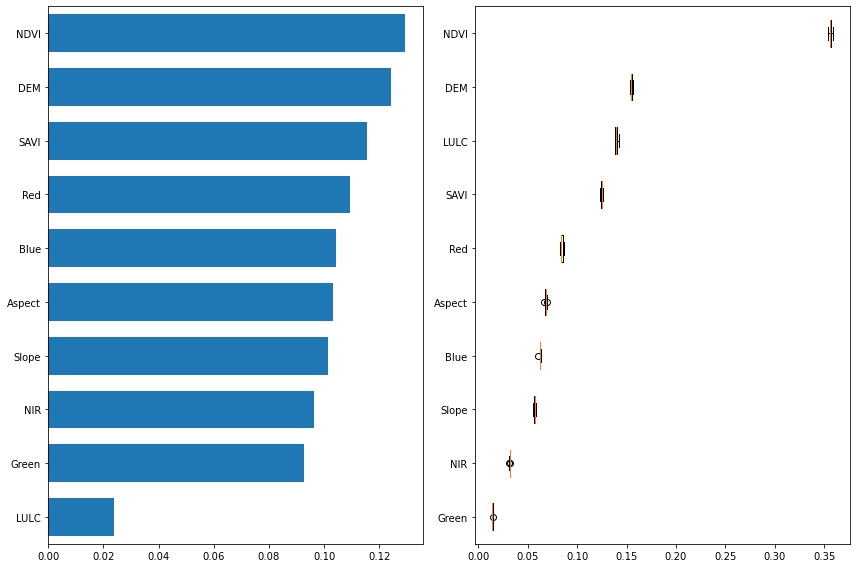

In [43]:
# For methods 1-4, use 10 features 
feature_names = ['Blue','Green','Red','NIR','NDVI','SAVI','DEM','Slope','Aspect','LULC']

# Combination of MDI and permutation importance (Vertical graphs)

result = permutation_importance(clf, X_train, y_train, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices, clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels([feature_names[i] for i in tree_importance_sorted_idx])
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=[feature_names[i] for i in perm_sorted_idx],
)
fig.tight_layout()
plt.show()